In [1]:
import datetime
from time import process_time
import re
import numpy as np
import matplotlib.patches as mpatches

import spacy
from random import sample

from textblob import TextBlob
import textblob.sentiments as tb
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.collocations import *
from nltk.metrics import BigramAssocMeasures

import pandas as pd

from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

**Setup**

In [2]:
sources = ['nytimes', 'CNN', 'bbcworld', 'theeconomist', 'reuters', 'WSJ', 'TIME', 'ABC', 'washingtonpost', 'AP']

In [3]:
#to get a string back to a datetime object
to_dt = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [4]:
#turns a string of a list of tuples back into a list of tuples ('loft')
def str_to_loft(loft):
    stack = []
    rebuilt = []

    for thing in loft.split(','):
        stack.append(thing.translate(str.maketrans('', '', '\'"[]()')).strip())
        if ')' in thing:
            rebuilt.append(tuple([stack.pop(), int(stack.pop()), stack.pop()][ : : -1]))
            
    return rebuilt

In [5]:
#some standard cleaning steps
def clean_text(text):
    clean = text.replace('…', '')
    if clean.startswith('RT @'):
        clean = ':'.join(clean.split(':')[1 : ])
        
    return clean.strip()

In [6]:
#from github!
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags = re.UNICODE)
    
    return emoji_pattern.sub(r'', string)

In [7]:
#Style:
sns.set_style('darkgrid')

#Context:
sns.set_context('notebook')

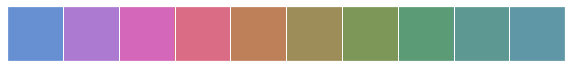

In [8]:
ORDER = ['nytimes', 'CNN', 'bbcworld', 'theeconomist', 'reuters', 'WSJ', 'TIME', 'ABC', 'washingtonpost', 'AP']
PAL = sns.husl_palette(10, l = 0.6, s = 0.6, h = 0.7)
SMALL_PAL = sns.husl_palette(7, l = 0.6, s = 0.6, h = 0.7)
EXT_PAL = sns.husl_palette(18, l = 0.6, s = 0.6, h = 0.7)

sns.palplot(PAL)

**Looking at NEs and setting up for following public figures:**

In [11]:
#getting tag breakdowns for each source
df = pd.read_csv('DATA/nytimes_FINAL.csv', index_col = 'ID')
df['Named_Entities'] = df['Named_Entities'].apply(str_to_loft)

types_freq = []

for x in df['Named_Entities']:
    if len(x) > 0:
        for i in x:
            types_freq.append(i[2])

tag_bdwn = {s : round(types_freq.count(s) / len(types_freq), 3) for s in set(types_freq)}

test_df = pd.DataFrame(columns = set(types_freq))
test_df.loc['nytimes'] = tag_bdwn

for s in sources[1 : ]:
    df = pd.read_csv('DATA/' + s + '_FINAL.csv', index_col = 'ID')
    df['Named_Entities'] = df['Named_Entities'].apply(str_to_loft)

    types_freq = []

    for x in df['Named_Entities']:
        if len(x) > 0:
            for i in x:
                types_freq.append(i[2])

    tag_bdwn = {s : round(types_freq.count(s) / len(types_freq), 3) for s in test_df.columns}

    test_df.loc[s] = tag_bdwn

In [254]:
for x in test_df.columns:
    test_df[x] = test_df[x] * 100

#all tags that are consistently lower than 5% (for 8 out of 10 sources) are put into 'OTHER'
test_df.drop(columns = ['EVENT', 'PRODUCT', 'QUANTITY', 'LANGUAGE', 'LAW', 'FAC', 'ORDINAL',\
                        'WORK_OF_ART', 'PERCENT', 'LOC', 'TIME', 'MONEY'], inplace = True)
test_df

,GPE,CARDINAL,NORP,ORG,PERSON,DATE
nytimes,23.8,11.9,7.0,10.9,15.9,18.2
CNN,21.8,11.6,5.5,16.9,18.3,13.8
bbcworld,33.3,12.4,8.4,10.6,15.5,9.7
theeconomist,25.9,9.3,9.5,9.9,12.1,15.1
reuters,33.5,9.6,9.2,16.6,12.1,9.2
WSJ,23.8,9.9,7.1,18.3,14.3,14.7
TIME,18.0,12.2,7.6,13.6,17.9,16.3
ABC,22.8,11.5,6.6,12.7,21.8,11.5
washingtonpost,24.4,10.1,7.7,18.0,14.6,10.4
AP,24.0,12.3,8.6,14.2,16.0,13.1


In [255]:
len(test_df.columns)

6

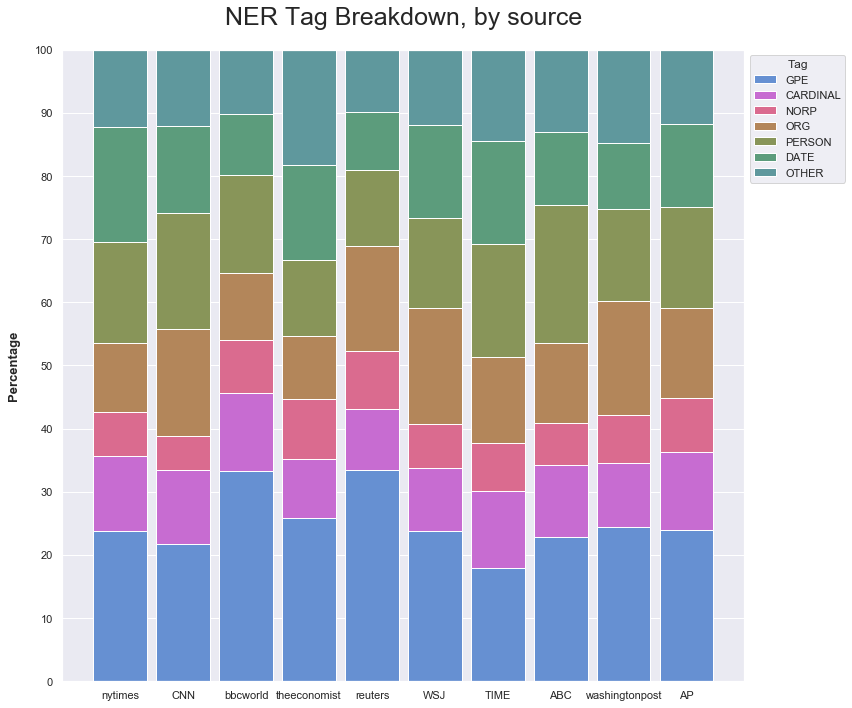

In [258]:
#stacked barplot for breakdown of tags
r = [i for i in range(len(test_df))]

plt.figure(figsize = (12, 10))

barWidth = 0.85

bottoms = pd.Series({s : 0 for s in sources})
colors = [tuple(x) for x in sns.husl_palette(len(test_df.columns) + 1, l = 0.6, s = 0.6, h = 0.7)]

for c, i in zip(test_df.columns, [x for x in range(len(test_df.columns) + 1)]):
    plt.bar(r, test_df[c], color = colors[i], bottom = bottoms, edgecolor = 'white', width = barWidth, label = c)
    bottoms = bottoms + test_df[c]

whats_left = pd.Series({s : 100 for s in sources}) - bottoms
plt.bar(r, whats_left, color = colors[-1], bottom = bottoms, edgecolor = 'white', width = barWidth, label = 'OTHER')

plt.title('NER Tag Breakdown, by source', fontsize = 25, pad = 25)
plt.ylabel('Percentage', fontsize = 13, labelpad = 15, **{'fontweight' : 'semibold'})
plt.ylim((0, 100))
plt.yticks([i for i in range(0, 110, 10)])
plt.xticks(r, test_df.index)
plt.legend(title = 'Tag', loc = 'upper left', bbox_to_anchor = (1, 1), ncol = 1)

plt.tight_layout()
plt.savefig('stacked_bar_NER_tags.png', dpi = 400)

**Splitting it up by COVID/non-COVID:**

In [10]:
#naive method for checking if a tweet is about COVID
def check_inc(x):
    if ('covid' in x.lower() or 'coronavirus' in x.lower()):
        #is about COVID
        return True
    #isn't about COVID
    return False

In [12]:
#getting split breakdowns
df = pd.read_csv('DATA/nytimes_FINAL.csv', index_col = 'ID')
df['Named_Entities'] = df['Named_Entities'].apply(str_to_loft)

types_freq_about = []
types_freq_not = []

for x, y in zip(df['Named_Entities'], df['Tweet_Text']):
    if len(x) > 0:
        if check_inc(y):
            for i in x:
                types_freq_about.append(i[2])
        else:
            for i in x:
                types_freq_not.append(i[2])

tag_bdwn_about = {s : round(types_freq_about.count(s) / len(types_freq_about), 3) for s in set(types_freq)}
tag_bdwn_about['Type'] = 1
tag_bdwn_not = {s : round(types_freq_not.count(s) / len(types_freq_not), 3) for s in set(types_freq)}
tag_bdwn_not['Type'] = 0

test_dfA = pd.DataFrame(columns = set(types_freq + ['Type']))

test_dfA.loc[0] = tag_bdwn_about
test_dfA.loc[1] = tag_bdwn_not

ct = 2
for so in sources[1 : ]:
    df = pd.read_csv('DATA/' + so +'_FINAL.csv', index_col = 'ID')
    df['Named_Entities'] = df['Named_Entities'].apply(str_to_loft)

    types_freq_about = []
    types_freq_not = []

    for x, y in zip(df['Named_Entities'], df['Tweet_Text']):
        if len(x) > 0:
            if check_inc(y):
                for i in x:
                    types_freq_about.append(i[2])
            else:
                for i in x:
                    types_freq_not.append(i[2])

    tag_bdwn_about = {s : round(types_freq_about.count(s) / len(types_freq_about), 3) for s in set(types_freq)}
    tag_bdwn_about['Type'] = 1
    tag_bdwn_not = {s : round(types_freq_not.count(s) / len(types_freq_not), 3) for s in set(types_freq)}
    tag_bdwn_not['Type'] = 0

    test_dfA.loc[ct] = tag_bdwn_about
    ct += 1
    test_dfA.loc[ct] = tag_bdwn_not
    ct += 1

other = test_dfA['EVENT']
to_drop = ['EVENT', 'PRODUCT', 'QUANTITY', 'LANGUAGE', 'LAW', 'FAC', 'ORDINAL','WORK_OF_ART', 'PERCENT', 'LOC', 'TIME', 'MONEY']
for x in to_drop[1 : ]:
    other = other + test_dfA[x]
test_dfA.drop(columns = to_drop, inplace = True)

test_dfA['OTHER'] = other
test_dfA

,CARDINAL,NORP,ORG,GPE,DATE,Type,PERSON,OTHER
0,0.132,0.060,0.104,0.298,0.179,1.0,0.108,0.121
1,0.112,0.075,0.111,0.202,0.183,0.0,0.189,0.125
2,0.127,0.048,0.184,0.243,0.119,1.0,0.167,0.111
3,0.103,0.062,0.150,0.189,0.161,0.0,0.201,0.136
4,0.152,0.079,0.101,0.352,0.092,1.0,0.113,0.112
5,0.099,0.088,0.111,0.316,0.102,0.0,0.192,0.091
6,0.059,0.067,0.090,0.321,0.146,1.0,0.080,0.236
7,0.100,0.101,0.101,0.246,0.152,0.0,0.130,0.169
8,0.131,0.090,0.134,0.373,0.085,1.0,0.098,0.088
9,0.066,0.094,0.194,0.302,0.098,0.0,0.140,0.105


In [15]:
abt = test_dfA[test_dfA['Type'] == 1].mean().drop('Type')
not_abt = test_dfA[test_dfA['Type'] == 0].mean().drop('Type')

final_df = pd.DataFrame(pd.concat([abt, not_abt]))
final_df['Type'] = (['Yes'] * 7) + (['No'] * 7)
final_df['Tag'] = final_df.index
final_df.rename(columns = {0 : 'Mean_Pctg'}, inplace = True)
final_df['Mean_Pctg'] = final_df['Mean_Pctg'] * 100
final_df

,Mean_Pctg,Type,Tag
CARDINAL,12.24,Yes,CARDINAL
NORP,7.00,Yes,NORP
ORG,13.61,Yes,ORG
GPE,29.52,Yes,GPE
DATE,11.92,Yes,DATE
PERSON,12.15,Yes,PERSON
OTHER,13.57,Yes,OTHER
CARDINAL,10.00,No,CARDINAL
NORP,8.06,No,NORP
ORG,14.44,No,ORG


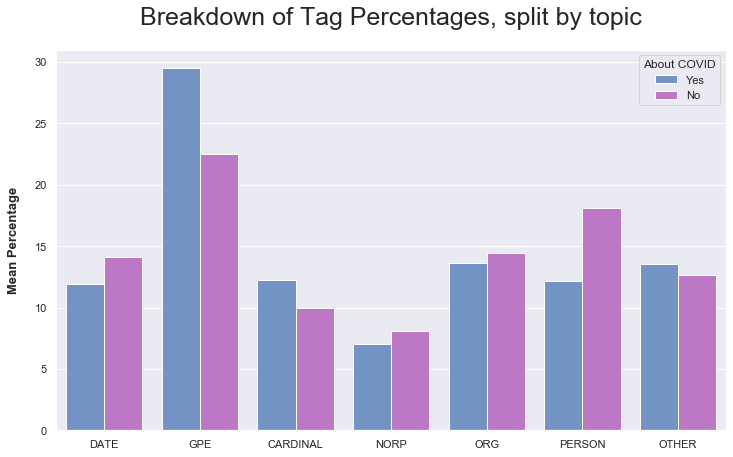

In [18]:
#comparing average breakdowns between COVID/non-COVID tweets
plt.figure(figsize = (12, 7))
o = ['DATE', 'GPE', 'CARDINAL', 'NORP', 'ORG', 'PERSON', 'OTHER']
pl = sns.barplot(data = final_df, x = 'Tag', y = 'Mean_Pctg', hue = 'Type', order = o, palette = SMALL_PAL)
pl.legend().set_title('About COVID')

plt.title('Breakdown of Tag Percentages, split by topic', pad = 25, fontsize = 25)
plt.xlabel('')
plt.ylabel('Mean Percentage', fontsize = 13, labelpad = 15, **{'fontweight' : 'semibold'})

plt.savefig('tag_breakdown_COVID_vs_not.png', dpi = 400)

**Looking at the most frequently included 'PEOPLE' NEs:**

In [9]:
#function to categorize by week
def assign_week(date):
    if datetime.datetime(2020, 3, 11) > date >= datetime.datetime(2020, 3, 4):
        return 1
    elif datetime.datetime(2020, 3, 18) > date >= datetime.datetime(2020, 3, 11): 
        return 2
    elif datetime.datetime(2020, 3, 25) > date >= datetime.datetime(2020, 3, 18): 
        return 3
    else: 
        return 4

In [11]:
#getting breakdown week-by-week
ner_df = pd.read_csv('DATA/' + sources[0] + '_FINAL.csv', index_col = 'ID')

for x in sources[1 : ]:
    ner_df = ner_df.append(pd.read_csv('DATA/' + x + '_FINAL.csv', index_col = 'ID'))
    
ner_df['User'] = ner_df['User'].str.lstrip('@').replace({'BBCWorld' : 'bbcworld', 'Reuters' : 'reuters', 'TheEconomist' : 'theeconomist'})
ner_df['About_COVID'] = ner_df['Tweet_Text'].fillna('').apply(lambda x: int(check_inc(x)))
ner_df['Named_Entities'] = ner_df['Named_Entities'].apply(str_to_loft)
ner_df['Date_Time'] = ner_df['Date_Time'].apply(to_dt)
ner_df['Week'] = ner_df['Date_Time'].apply(assign_week)

people = {'Week 1' : [], 'Week 2' : [], 'Week 3' : [], 'Week 4' : []}
covid_people = {'Week 1' : [], 'Week 2' : [], 'Week 3' : [], 'Week 4' : []}

#grabbing the people and sorting into weeks
for x in ner_df.index:
    c = ner_df.loc[x]['Named_Entities']
    d = ner_df.loc[x]['Week']
    about = ner_df.loc[x]['About_COVID'] == 1
    if len(c) > 0:
        if about:
            for i in c:
                if i[2] == 'PERSON':
                    people['Week ' + str(d)].extend([i[0]] * i[1])
                    covid_people['Week ' + str(d)].extend([i[0]] * i[1])
        else:
            for i in c:
                if i[2] == 'PERSON':
                    people['Week ' + str(d)].extend([i[0]] * i[1])

In [12]:
print(len(people['Week 4']), len(covid_people['Week 4']))

3047 1367


In [13]:
max_len = max([len(v) for v in people.values()])

for k in people:
    people[k].extend([''] * (max_len - len(people[k]))) 
    
ppl_df = pd.DataFrame(people)
ppl_df = ppl_df.replace('', np.nan)

#there are ones that we're unsure about... best to just not include them in figures!
#maybe: {'Meghan' : 'Meghan Markle', 'Johnson' : 'Boris Johnson', 'Pres' : 'Donald Trump',
#        'Cuomo' : 'Andrew Cuomo', 'Abe' : 'Shinzo Abe'}
ppl_to_rep = {'Trump' : 'Donald Trump', 'Putin' : 'Vladimir Putin', 'Bolsonaro' : 'Jair Bolsonaro', 
              'Fauci' : 'Anthony Fauci', 'Netanyahu' : 'Benjamin Netanyahu', 'Warren' : 'Elizabeth Warren',
              'Joe Bidens' : 'Joe Biden', 'Biden' : 'Joe Biden', 'Mike Bloomberg' : 'Michael Bloomberg',
              'Pence' : 'Mike Pence', 'Elizabeth Warrens' : 'Elizabeth Warren', 'Trudeau' : 'Justin Trudeau',
              'Weinstein' : 'Harvey Weinstein'}

ppl_dfA = ppl_df.replace(ppl_to_rep)

In [14]:
max_len = max([len(v) for v in covid_people.values()])

for k in covid_people:
    covid_people[k].extend([''] * (max_len - len(covid_people[k]))) 
    
covid_ppl_df = pd.DataFrame(covid_people)
covid_ppl_df = covid_ppl_df.replace('', np.nan)

covid_ppl_dfA = covid_ppl_df.replace(ppl_to_rep)

In [15]:
covid_ppl_dfA['Week 4'].value_counts()

Donald Trump             228
Andrew Cuomo              67
Anthony Fauci             47
Boris Johnson             36
Joe Biden                 27
Vladimir Putin            26
Prince Charles            22
Johnson                   22
Cuomo                     17
Jair Bolsonaro            16
Nancy Pelosi              14
Chris Cuomo               14
Bernie Sanders            12
Vincent van Gogh          10
Gavin Newsom               9
Pres                       9
Charles                    8
Easter                     7
Julie Gerberding           7
Justin Trudeau             7
Ron DeSantis               7
Eric Garcetti              7
Bill de Blasio             6
Thomas Massie              6
Vijay Vaitheeswaran        6
Claire Hopkins             6
Pope                       6
Robin Williams             6
Mike Pence                 6
Tom Hanks                  6
                        ... 
’s Diary                   1
Florida Keys               1
Juan Guaidó                1
Greg Rikaart  

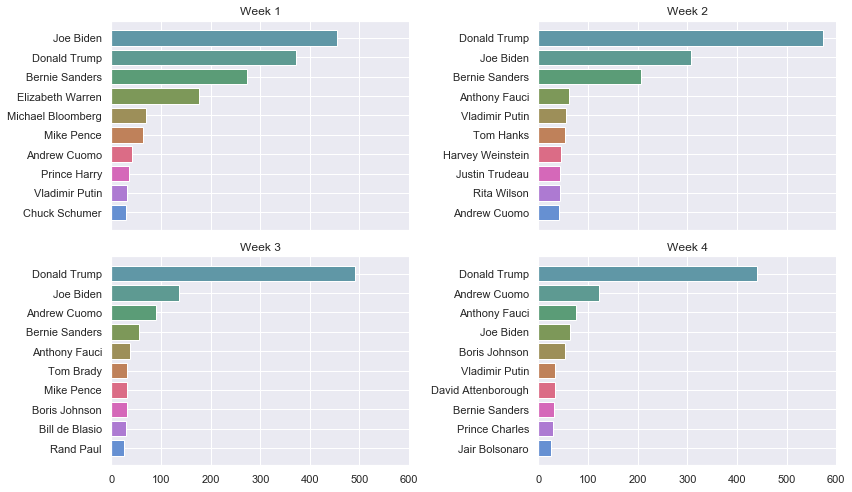

In [611]:
#most referenced 'PEOPLE' NEs, all tweets
fig, axs = plt.subplots(2, 2, figsize = (12, 7), sharex = True)

#1 woman
datum = ppl_dfA['Week 1'].value_counts().drop('Meghan')
axs[0, 0].barh(datum.index[ : 10][ : : -1], datum[ : 10][ : : -1], color = PAL)
axs[0, 0].set_title('Week 1')

#1 woman
datum = ppl_dfA['Week 2'].value_counts()
axs[0, 1].barh(datum.index[ : 10][ : : -1], datum[ : 10][ : : -1], color = PAL)
axs[0, 1].set_title('Week 2')

#0 women
datum = ppl_dfA['Week 3'].value_counts()
axs[1, 0].barh(datum.index[ : 10][ : : -1], datum[ : 10][ : : -1], color = PAL)
axs[1, 0].set_title('Week 3')

#0 women
datum = ppl_dfA['Week 4'].value_counts().drop(['Cuomo', 'Johnson'])
axs[1, 1].barh(datum.index[ : 10][ : : -1], datum[ : 10][ : : -1], color = PAL)
axs[1, 1].set_title('Week 4')

fig.tight_layout()
plt.savefig('most_referenced_people_OVERALL.png', dpi = 400)

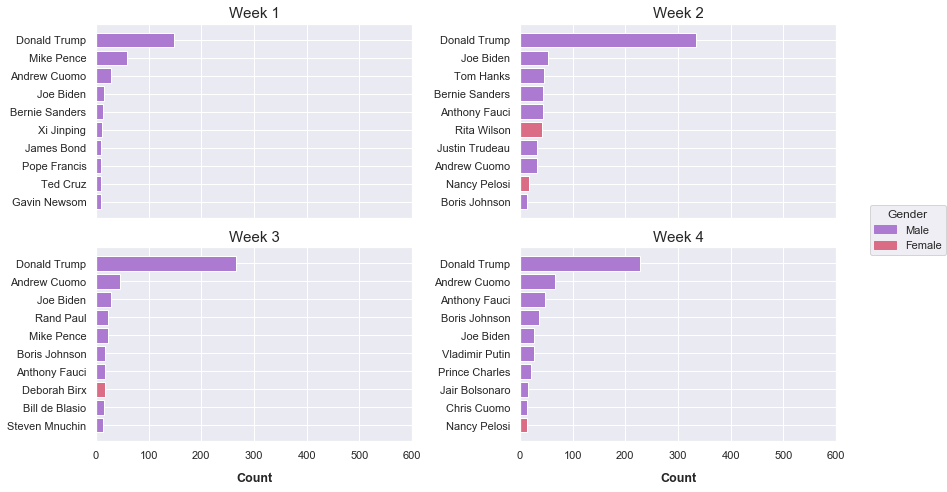

In [619]:
#most referenced 'PEOPLE' NEs, COVID tweets
fig, axs = plt.subplots(2, 2, figsize = (12, 7), sharex = True)

#0 women
colors = [PAL[1]] * 10
datum = covid_ppl_dfA['Week 1'].value_counts().drop('Pres')
axs[0, 0].barh(datum.index[ : 10][ : : -1], datum[ : 10][ : : -1], color = colors[ : : -1])
axs[0, 0].set_title('Week 1', fontdict = {'fontsize' : 15})

#2 women
colors = [PAL[1], PAL[1], PAL[1], PAL[1], PAL[1], PAL[3], PAL[1], PAL[1], PAL[3], PAL[1]]
datum = covid_ppl_dfA['Week 2'].value_counts()
axs[0, 1].barh(datum.index[ : 10][ : : -1], datum[ : 10][ : : -1], color = colors[ : : -1])
axs[0, 1].set_title('Week 2', fontdict = {'fontsize' : 15})

#1 woman
colors = [PAL[1], PAL[1], PAL[1], PAL[1], PAL[1], PAL[1], PAL[1], PAL[3], PAL[1], PAL[1]]
datum = covid_ppl_dfA['Week 3'].value_counts()
axs[1, 0].barh(datum.index[ : 10][ : : -1], datum[ : 10][ : : -1], color = colors[ : : -1])
axs[1, 0].set_title('Week 3', fontdict = {'fontsize' : 15})
axs[1, 0].set_xlabel('Count', fontsize = 12.5, labelpad = 12, **{'fontweight' : 'semibold'})

#1 woman
colors = [PAL[1], PAL[1], PAL[1], PAL[1], PAL[1], PAL[1], PAL[1], PAL[1], PAL[1], PAL[3]]
datum = covid_ppl_dfA['Week 4'].value_counts().drop(['Johnson', 'Cuomo'])
axs[1, 1].barh(datum.index[ : 10][ : : -1], datum[ : 10][ : : -1], color = colors[ : : -1])
axs[1, 1].set_title('Week 4', fontdict = {'fontsize' : 15})
axs[1, 1].set_xlabel('Count', fontsize = 12.5, labelpad = 12, **{'fontweight' : 'semibold'})

plt.setp(axs, xlim = (0, 600))

c1 = mpatches.Patch(color = PAL[1], label = 'Male')
c2 = mpatches.Patch(color = PAL[3], label = 'Female')
fig.legend(title = 'Gender', handles = [c1, c2], loc = 'upper left', bbox_to_anchor = (1, 0.58))

fig.tight_layout()
plt.savefig('most_referenced_people_ABOUT_COVID.png', bbox_inches = 'tight', dpi = 400)

In [16]:
#getting overall breakdown of people, not splitting by week
all_covid_ppl = []

for l in covid_people:
    all_covid_ppl.extend([e for e in covid_people[l] if e != ''])
    
all_series = pd.Series(all_covid_ppl)
all_series = all_series.replace(ppl_to_rep)

#the NEs that we're going to follow with SA
to_follow = list(all_series.value_counts().index[ : 5])
to_follow

['Donald Trump', 'Andrew Cuomo', 'Joe Biden', 'Anthony Fauci', 'Mike Pence']

In [22]:
all_series.value_counts()[ : 35]

Donald Trump          977
Andrew Cuomo          172
Joe Biden             124
Anthony Fauci         115
Mike Pence            103
Bernie Sanders         76
Boris Johnson          68
Tom Hanks              60
Rita Wilson            52
Justin Trudeau         43
Nancy Pelosi           43
Vladimir Putin         42
Jair Bolsonaro         40
Pres                   39
Cuomo                  36
Bill de Blasio         34
Gavin Newsom           29
Johnson                26
Prince Charles         25
Deborah Birx           25
Rand Paul              24
Steven Mnuchin         23
Benjamin Netanyahu     23
Pope Francis           19
Mitch McConnell        18
Angela Merkel          17
Chuck Schumer          17
Richard Burr           16
Xi Jinping             15
Obama                  15
Chris Cuomo            14
PM Johnson             13
Jack Ma                13
Larry Hogan            13
Narendra Modi          12
dtype: int64

In [31]:
top = all_series.value_counts()[0 : 11]
print(top)

#format: '(w/trump, w/out trump)''
men = (top[ : 8].sum() + top['Justin Trudeau'], top[1 : 8].sum() + top['Justin Trudeau'])
women = (top['Rita Wilson'] + top['Nancy Pelosi'], top['Rita Wilson'] + top['Nancy Pelosi'])
print('\nRatio of men to women mentions in top ten... \nWith Trump: %s to 1\nWithout Trump: %s to 1'\
      % (men[0] / women[0], men[1] / women[1]))

Donald Trump      977
Andrew Cuomo      172
Joe Biden         124
Anthony Fauci     115
Mike Pence        103
Bernie Sanders     76
Boris Johnson      68
Tom Hanks          60
Rita Wilson        52
Justin Trudeau     43
Nancy Pelosi       43
dtype: int64

Ratio of men to women mentions in top ten... 
With Trump: 18.294736842105262 to 1
Without Trump: 8.010526315789473 to 1


**Perception of public figures:**

In [15]:
ner_dfA = pd.read_csv('DATA/' + sources[0] + '_FINAL.csv', index_col = 'ID')

for x in sources[1 : ]:
    ner_dfA = ner_dfA.append(pd.read_csv('DATA/' + x + '_FINAL.csv', index_col = 'ID'))
    
ner_dfA['User'] = ner_dfA['User'].str.lstrip('@').replace({'BBCWorld' : 'bbcworld', 'Reuters' : 'reuters', 'TheEconomist' : 'theeconomist'})
ner_dfA['About_COVID'] = ner_dfA['Tweet_Text'].fillna('').apply(lambda x: int(check_inc(x)))
ner_dfA['Named_Entities'] = ner_dfA['Named_Entities'].apply(str_to_loft)
ner_dfA['Date_Time'] = ner_dfA['Date_Time'].apply(to_dt)

In [13]:
ner_dfA.tail()

,User,Source_Name,Tweet_Text,Date_Time,Sentiment,Named_Entities,About_COVID
ID,,,,,,,
1245489137161043971,AP,The Associated Press,RT @AP_NFL: Since Tom Brady took over for an i...,2020-04-01 23:12:05,0.042,"[(Tom Brady, 1, PERSON), (Drew Bledsoe, 1, PER...",0
1245493665998548993,AP,The Associated Press,RT @APCentralRegion: AP Video: Amid panic-buyi...,2020-04-01 23:30:04,-0.033,"[(AP, 1, ORG), (Texas, 1, GPE)]",0
1245494426358755328,AP,The Associated Press,-Why are people with the virus in Germany dyin...,2020-04-01 23:33:06,-0.052,"[(Germany, 1, GPE)]",1
1245495656443195397,AP,The Associated Press,Background checks surged to their highest leve...,2020-04-01 23:37:59,0.000,"[(Background, 1, ORG), (March, 1, DATE), (Amer...",1
1245498197184778241,AP,The Associated Press,Country singer Caylee Hammack and her band are...,2020-04-01 23:48:05,-0.156,"[(Caylee Hammack, 1, PERSON)]",1


In [16]:
#check for the inclusion of a certain 'PERSON' NE
def has_person(loft, poss):
    for x in loft:
        if x[0].lower().rstrip('s') in poss:
            return True
    return False

In [19]:
#james bond???
ner_dfA[ner_dfA['Named_Entities'].apply(has_person, args = (['james bond'],))]

,User,Source_Name,Tweet_Text,Date_Time,Sentiment,Named_Entities,About_COVID
ID,,,,,,,
1235256955352109056,nytimes,The New York Times,The producers of the James Bond movie franchis...,2020-03-04 17:33:02,0.375,"[(James Bond, 1, PERSON), (“No Time To Die, 1,...",1
1235281379849637889,CNN,CNN,"""No Time To Die,"" the upcoming James Bond film...",2020-03-04 19:10:06,-0.062,"[(No Time To Die, 1, WORK_OF_ART), (James Bond...",1
1235460288897593344,CNN,CNN,"""No Time To Die,"" the upcoming James Bond film...",2020-03-05 07:01:01,-0.062,"[(No Time To Die, 1, WORK_OF_ART), (James Bond...",1
1235544964014190593,CNN,CNN,"""No Time To Die,"" the upcoming James Bond film...",2020-03-05 12:37:29,-0.062,"[(No Time To Die, 1, WORK_OF_ART), (James Bond...",1
1236026300390916097,CNN,CNN,"""No Time to Die,"" the latest James Bond film, ...",2020-03-06 20:30:08,0.203,"[(James Bond, 1, PERSON), (first, 1, ORDINAL),...",1
1236152310084100096,CNN,CNN,"""No Time to Die,"" the latest James Bond film, ...",2020-03-07 04:50:51,0.203,"[(James Bond, 1, PERSON), (first, 1, ORDINAL),...",1
1235253183569629184,bbcworld,BBC News (World),RT @BBCNews: Release of new James Bond film pu...,2020-03-04 17:18:03,0.068,"[(James Bond, 1, PERSON), (seven months to Nov...",1
1243577228723728391,reuters,Reuters,Now listen carefully 007: James Bond guns stol...,2020-03-27 16:34:50,-0.100,"[(007, 1, CARDINAL), (James Bond, 1, PERSON), ...",0
1245320457777184770,TIME,TIME,"From James Bond classics to ""The Lighthouse""",2020-04-01 12:01:48,0.000,"[(James Bond, 1, PERSON), (The Lighthouse, 1, ...",0


In [17]:
#COVID tweets that contain each of the figures

#handpicked possibilites:
possible_trumps = ['donald trump', 'trump', 'president trump', 'pres trump', 'pres. trump']
possible_cuomos = ['andrew cuomo', 'governer cuomo']
possible_bidens = ['biden', 'joe biden', 'vice president biden', 'vice president joe biden']
possible_faucis = ['fauci', 'anthony fauci']
possible_pences = ['vice president mike pence', 'vice president pence', 'pence', 'mike pence', 'michael pence']

sub = ner_dfA[ner_dfA['About_COVID'] == 1].copy()

fig_ser = sub['Named_Entities'].apply(lambda x: has_person(x, possible_trumps))
fig_df = sub[fig_ser].copy()
fig_df['Person'] = ['Trump'] * len(fig_df)

for l, p in zip([possible_cuomos, possible_bidens, possible_faucis, possible_pences], ['Cuomo', 'Biden', 'Fauci', 'Pence']):
    fig_ser = sub['Named_Entities'].apply(lambda x: has_person(x, l))
    to_add = sub[fig_ser].copy()
    to_add['Person'] = [p] * len(to_add) 
    fig_df = fig_df.append(to_add)

fig_df.head()

,User,Source_Name,Tweet_Text,Date_Time,Sentiment,Named_Entities,About_COVID,Person
ID,,,,,,,,
1235314090496716800,nytimes,The New York Times,President Trump responded to criticism over hi...,2020-03-04 21:20:04,0.000,"[(Trump, 2, PERSON), (Obama, 1, PERSON)]",1,Trump
1235923107086569472,nytimes,The New York Times,President Trump at the last minute scrapped pl...,2020-03-06 13:40:05,-0.050,"[(Trump, 1, PERSON), (the last minute, 1, TIME...",1,Trump
1236104295835152384,nytimes,The New York Times,"In Opinion @michelleinbklyn writes, “So far, ...",2020-03-07 01:40:04,-0.333,"[(Donald Trump, 1, PERSON)]",1,Trump
1236416361116598277,nytimes,The New York Times,Debate has raged in the Trump administration o...,2020-03-07 22:20:06,0.000,"[(Trump, 1, PERSON)]",1,Trump
1236647876673130496,nytimes,The New York Times,"An attendee of CPAC, where President Trump and...",2020-03-08 13:40:04,0.076,"[(Trump, 1, PERSON), (Mike Pence, 1, PERSON), ...",1,Trump


In [18]:
#slight descrepancy here... not in complete agreement with the counts from "all_series"
fig_df['Person'].value_counts()

Trump    1199
Cuomo     172
Biden     136
Pence     116
Fauci     114
Name: Person, dtype: int64

In [19]:
#building dataframe for line plot
int_line = fig_df[['User', 'Date_Time', 'Sentiment', 'Person']]
int_line.set_index('Date_Time', inplace = True)

for_line = int_line[int_line['Person'] == 'Trump'].resample('3D').mean()
for_line['Person'] = ['Trump'] * len(for_line)

for p in int_line['Person'].unique()[1 : ]:
    to_add = int_line[int_line['Person'] == p].resample('3D').mean()
    to_add['Person'] = [p] * len(to_add)
    for_line = for_line.append(to_add)

for_line['DT'] = for_line.index    
for_line['Person'].value_counts()

Pence    10
Cuomo    10
Trump    10
Fauci    10
Biden    10
Name: Person, dtype: int64

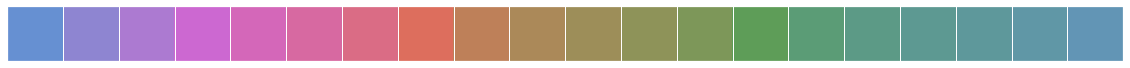

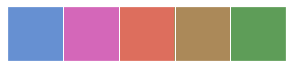

In [20]:
to_choose = sns.husl_palette(20, l = 0.6, s = 0.6, h = 0.7)
sns.palplot(to_choose)

colors = [to_choose[0], to_choose[4], to_choose[7], to_choose[9], to_choose[13]]
sns.palplot(colors)

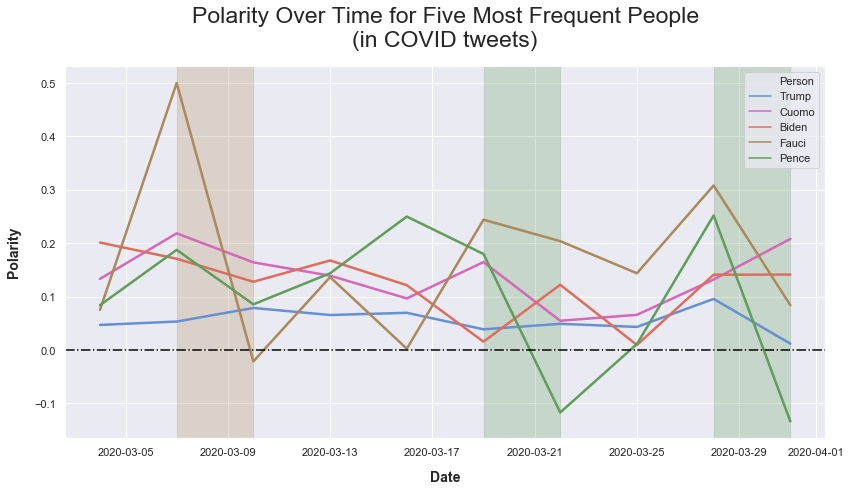

In [36]:
#following polarity associated with top five public figures
plt.figure(figsize = (12, 7))
ln = sns.lineplot(data = for_line, x = 'DT', y = 'Sentiment', hue = 'Person', palette = colors, lw = 2.5)

#adding zero line
ln.axhline(0, ls = '-.', color = 'k')

plt.ylabel('Polarity', fontsize = 14, labelpad = 13, **{'fontweight' : 'semibold'})
plt.xlabel('Date', fontsize = 14, labelpad = 13, **{'fontweight' : 'semibold'})
plt.legend(loc = 'upper right')
plt.title('Polarity Over Time for Five Most Frequent People\n(in COVID tweets)', fontsize = 23, pad = 20)

#manually adding vertical shaded regions
plt.axvspan('2020-03-07', '2020-03-10', alpha = 0.25, color = to_choose[9])
plt.axvspan('2020-03-19', '2020-03-22', alpha = 0.25, color = to_choose[13])
plt.axvspan('2020-03-28', '2020-03-31', alpha = 0.25, color = to_choose[13])

plt.tight_layout()
plt.savefig('polarity_line_for_top_five_people_SHADED.png', dpi = 400)